In [84]:
import sys
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.functions import *

In [85]:
 spark = SparkSession\
 .builder\
 .appName("SparkETL")\
 .getOrCreate()

In [86]:
df = spark.read.option('delimiter',';').option('inferSchema','true').option('header','true').csv('s3://s3-udea.ds.s3.amazonaws.com/input/Saber11.csv')

In [87]:
df.show()

+--------+-----------+--------+---+---------+--------+-------+--------+------------+-------+-------+------+------------------+
|lenguaje|matematicas|sociales| Id|filosofia|biologia|quimica|  fisica|nivel_ingles| sisben|estrato|genero|puntaje_saber11   |
+--------+-----------+--------+---+---------+--------+-------+--------+------------+-------+-------+------+------------------+
|    alto|       alto|    alto|  1|    medio|   medio|  medio|superior|          A1|      2|      3|Hombre|              bajo|
|   medio|       bajo|   medio|  2|    medio|   medio|   alto|    alto|          A1|      1|      1|Hombre|              bajo|
|   medio|      medio|   medio|  3|     alto|   medio|  medio|   medio|          A1|      5|      3| Mujer|              bajo|
|   medio|      medio|   medio|  4|    medio|   medio|   alto|    alto|          A2|      5|      4|Hombre|              bajo|
|   medio|      medio|   medio|  5|    medio|   medio|  medio|    alto|          A1|      1|      1|Hombre|    

In [88]:
df.columns

['lenguaje',
 'matematicas',
 'sociales',
 'Id',
 'filosofia',
 'biologia',
 'quimica',
 'fisica',
 'nivel_ingles',
 ' sisben',
 'estrato',
 'genero',
 'puntaje_saber11   ']

In [89]:
df = df.withColumnRenamed(' sisben', 'sisben')
df = df.withColumnRenamed('puntaje_saber11   ', 'puntaje_saber11')

In [90]:
df.printSchema()
df.show(5, truncate=False)

root
 |-- lenguaje: string (nullable = true)
 |-- matematicas: string (nullable = true)
 |-- sociales: string (nullable = true)
 |-- Id: integer (nullable = true)
 |-- filosofia: string (nullable = true)
 |-- biologia: string (nullable = true)
 |-- quimica: string (nullable = true)
 |-- fisica: string (nullable = true)
 |-- nivel_ingles: string (nullable = true)
 |-- sisben: integer (nullable = true)
 |-- estrato: integer (nullable = true)
 |-- genero: string (nullable = true)
 |-- puntaje_saber11: string (nullable = true)

+--------+-----------+--------+---+---------+--------+-------+--------+------------+------+-------+------+---------------+
|lenguaje|matematicas|sociales|Id |filosofia|biologia|quimica|fisica  |nivel_ingles|sisben|estrato|genero|puntaje_saber11|
+--------+-----------+--------+---+---------+--------+-------+--------+------------+------+-------+------+---------------+
|alto    |alto       |alto    |1  |medio    |medio   |medio  |superior|A1          |2     |3      |Ho

In [91]:
columns = df.columns
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in columns])
null_counts.show()

+--------+-----------+--------+---+---------+--------+-------+------+------------+------+-------+------+---------------+
|lenguaje|matematicas|sociales| Id|filosofia|biologia|quimica|fisica|nivel_ingles|sisben|estrato|genero|puntaje_saber11|
+--------+-----------+--------+---+---------+--------+-------+------+------------+------+-------+------+---------------+
|       0|          0|       0|  0|        0|       0|      0|     0|           0|     0|      0|     0|              0|
+--------+-----------+--------+---+---------+--------+-------+------+------------+------+-------+------+---------------+



In [92]:
categorical_columns = ['lenguaje', 'matematicas', 'sociales', 'filosofia', 'biologia', 'quimica', 'fisica', 'nivel_ingles', 'genero', 'puntaje_saber11']

In [93]:
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(df) for col in categorical_columns]
encoders = [OneHotEncoder(inputCols=[col + "_index"], outputCols=[col + "_vec"]) for col in categorical_columns]

In [94]:
pipeline = Pipeline(stages=indexers + encoders)
df_encoded = pipeline.fit(df).transform(df)

In [95]:
numerical_cols = ['sisben', 'estrato']
encoded_columns = [c + '_vec' for c in categorical_columns] + numerical_cols
df_encoded = df_encoded.select(*encoded_columns)

In [96]:
assembler = VectorAssembler(inputCols=encoded_columns, outputCol='features')
df_features = assembler.transform(df_encoded)

In [97]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

In [98]:
def run_kmeans(n_clusters):
    kmeans = KMeans(k=n_clusters, seed=1, featuresCol='scaled_features', predictionCol='cluster')
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)
    evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='scaled_features')
    silhouette = evaluator.evaluate(predictions)
    return model, silhouette

In [99]:
cluster_silhouette = {}
for n_clusters in range(2, 11):  # De 2 a 10 clusters
    model, silhouette = run_kmeans(n_clusters)
    cluster_silhouette[n_clusters] = silhouette

print(cluster_silhouette)

{2: 0.2578251964042838, 3: 0.27207218120052673, 4: 0.12042505490725162, 5: 0.14726568032901052, 6: 0.1592453592368426, 7: 0.14782259961560076, 8: 0.20527784567313648, 9: 0.16944788938739855, 10: 0.18512189694096792}


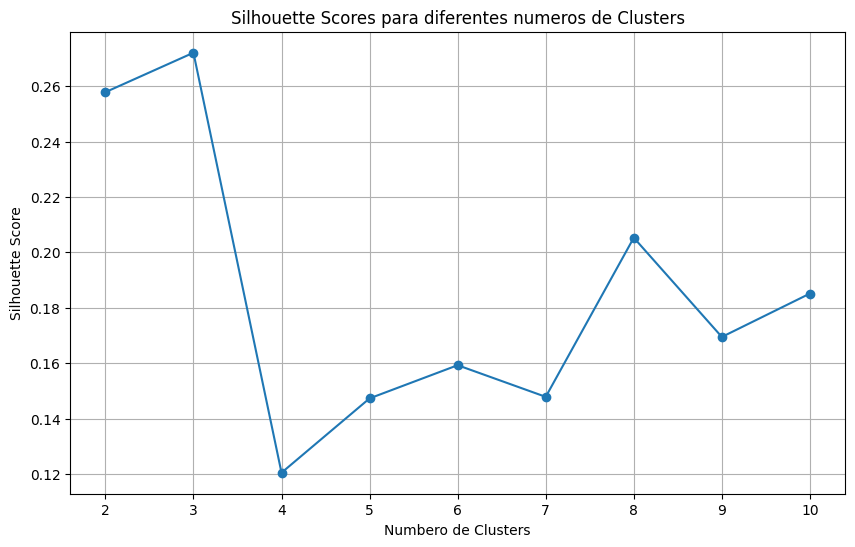

In [100]:
import matplotlib.pyplot as plt

clusters = list(cluster_silhouette.keys())
scores = list(cluster_silhouette.values())

plt.figure(figsize=(10, 6))
plt.plot(clusters, scores, marker='o')
plt.xlabel('Numbero de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores para diferentes numeros de Clusters')
plt.grid(True)
plt.show()

In [101]:
chosen_clusters = 3  # Al parecer 3 es el numero optimo de clusters
final_model, final_silhouette = run_kmeans(chosen_clusters)
print(final_silhouette)

0.27207218120052673


# Para la elección del número de clústeres, utilizamos la puntuación de Silhouette, que mide qué tan bien está un punto dentro de su clúster en comparación con otros clústeres. Gráficamente, la puntuación es mayor para el número 3, lo que sugiere que 3 clústeres son adecuados para los datos.

In [102]:
encoded_columns = [c + '_vec' for c in categorical_columns] + numerical_cols

In [110]:
centroid_1 = dict(zip(encoded_columns, centroids[0]))
centroid_2 = dict(zip(encoded_columns, centroids[1]))
centroid_3 = dict(zip(encoded_columns, centroids[2]))

In [112]:
print("Centroide para el Cluster 1:")
for col, val in centroid_1.items():
    print(f"{col}: {val}")

Centroide para el Cluster 1:
lenguaje_vec: 1.794089662620157
matematicas_vec: 0.27950739781363554
sociales_vec: 0.0
filosofia_vec: 1.6395695060789903
biologia_vec: 0.24463158110223687
quimica_vec: 0.3602463800754305
fisica_vec: 1.6714256117425432
nivel_ingles_vec: 0.32627069799290165
genero_vec: 0.09519289050244935
puntaje_saber11_vec: 0.7754877304134256
sisben: 1.2214952687278395
estrato: 0.030156156889136965


# Este clúster agrupa a estudiantes con un rendimiento alto en lenguaje, filosofía, y física. El nivel socioeconómico (estrato) de estos estudiantes parece ser bajo, pero tienen un nivel de sisben moderado, lo que puede indicar que reciben algún tipo de apoyo social.

In [105]:
print("Centroide para el Cluster 2:")
for col, val in centroid_2.items():
    print(f"{col}: {val}")

Centroide para el Cluster 2:
lenguaje_vec: 0.015577948989951813
matematicas_vec: 0.0
sociales_vec: 8.849107069922567
filosofia_vec: 1.5083000179257642
biologia_vec: 0.1399474546256708
quimica_vec: 0.9331193829773385
fisica_vec: 1.7079423479507059
nivel_ingles_vec: 0.12113626197656652
genero_vec: 1.3150456452368453
puntaje_saber11_vec: 0.5000411786583724
sisben: 1.4236332106517964
estrato: 0.0


# Este clúster parece agrupar a estudiantes con un rendimiento excepcional en sociales. Estos estudiantes también muestran un buen rendimiento en filosofía y física. El nivel socioeconómico es muy bajo, pero tienen un sisben moderado.

In [109]:
print("Centroide para el Cluster 3:")
for col, val in centroid_3.items():
    print(f"{col}: {val}")

Centroide para el Cluster 3:
lenguaje_vec: 0.7732159244206773
matematicas_vec: 1.2862930028073174
sociales_vec: 0.0
filosofia_vec: 0.6251631625176731
biologia_vec: 1.403299328260333
quimica_vec: 0.014736796362203593
fisica_vec: 0.43009438640055253
nivel_ingles_vec: 1.5672132324370165
genero_vec: 0.003090561754603132
puntaje_saber11_vec: 1.5666144768801475
sisben: 0.34968582310395635
estrato: 0.3172151465132124


# Este clúster agrupa a estudiantes con un buen rendimiento en matemáticas, biología, y nivel de inglés. Estos estudiantes también tienen un puntaje_saber11 alto, lo que indica un rendimiento académico general bueno. Por otro lado, tanto el sisben como el estrato son bajos, lo que sugiere que estos estudiantes provienen de un entorno socioeconómico menos favorable.